In [1]:
import pandas as pd
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, mapping
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import regionmask
import xesmf as xe
import cmocean

import sys
sys.path.append('../')
import utils
import plotting

import math

# Import Data and Count mortalities

In [2]:
ds_o3 = xr.open_zarr('./final_data/o3_mortalities.zarr')
ds_PM = xr.open_zarr('./final_data/pm_mortalities.zarr')

In [3]:
#create seasonal averages-- summer ozone is 8 hour afternoon, winter ozone is daily, pm is daily
ds_seasonal = utils.season_mean(ds_PM)
ds_seasonal = ds_seasonal

#rename ozone and convert to ppb
ds_o3 = ds_o3.rename({'SpeciesConc_O3':'O3'})
ds_o3['O3'] *= 1e9



#combine the two datasets
ds_seasonal['O3'].loc[ds_seasonal['season'] == 'JJA'] = ds_o3['O3'] #override the summer average with the 8 hour afternoon average
ds_seasonal['PM25'].attrs = {'units':r'$u$g/m3'}
ds_seasonal['O3'].attrs = {'units':'ppb'}

#list of model names
model_names = ds_PM['model_name'].values


## Mask data to US

In [4]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(ds_seasonal, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
ds_seasonal = ds_seasonal.where(contiguous_mask)


# Plot

## No Nuclear

In [7]:
### pollution color bar ####

cbar2_ax = fig.add_axes([.495, 0.23, 0.015, 0.5])
cb2 = fig.colorbar(pc2, cax=cbar2_ax)
cbar2_ax.tick_params(labelsize=10) 

#cb2.set_label(label = , fontsize=14)
cb2.ax.tick_params(labelsize='large')

NameError: name 'pc2' is not defined

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


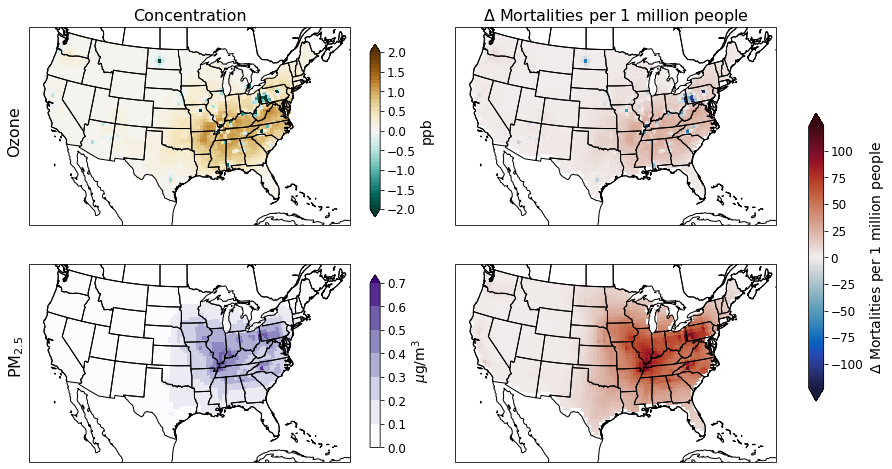

In [8]:
fig = plt.figure(figsize=[14,8])

### O3 No Nuclear plot ###
cmap = 'BrBG_r'
lev = np.squeeze(np.arange(-123,123.5,.5))
lev_pol =  np.squeeze(np.arange(-2.0,2.1,.1))
ax_o3 = fig.add_subplot(2,2,1, projection=ccrs.LambertConformal())
o3 = (ds_seasonal['O3'].sel(season ='JJA', model_name = 'nonuc_NA')-ds_seasonal['O3'].sel(season ='JJA', model_name = 'normal_NA')).plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev_pol, 
                                                                                  extend = 'both')
ax_o3.set_title('Concentration', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent([-120,-70,20,50])

## O3 colorbar ##
cbar_ax = fig.add_axes([.48, 0.55, 0.01, 0.3])
cb = fig.colorbar(o3, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'ppb', fontsize=14)
cb.ax.tick_params(labelsize='large')


### O3 No Nuclear Mortalities ###
cmap = cmocean.cm.balance
ax_o3_mort = fig.add_subplot(2,2,2, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_NA')/ds_o3['regrid_pop_count']).plot(ax = ax_o3_mort,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_mort.set_title('$\Delta$ Mortalities per 1 million people', fontsize = 16)
ax_o3_mort.add_feature(cfeat.STATES)
ax_o3_mort.coastlines()
ax_o3_mort.set_extent([-120,-70,20,50])

### PM No Nuclear plot ###
cmap = 'Purples'
lev_pol =  np.squeeze(np.arange(0,.8,.1))
ax_pm = fig.add_subplot(2,2,3, projection=ccrs.LambertConformal())
pm = (ds_seasonal['PM25'].sel( model_name = 'nonuc_NA')-ds_seasonal['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'season').plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev_pol, 
                                                         extend = 'max')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent([-120,-70,20,50])

## PM colorbar ##
cbar_ax = fig.add_axes([.48, 0.15, 0.01, 0.3])
cb = fig.colorbar(pm, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'$\mu$g/m$^3$', fontsize=14)
cb.ax.tick_params(labelsize='large')


### PM No Nuclear Mortalities###
cmap = cmocean.cm.balance
ax_pm_mort = fig.add_subplot(2,2,4, projection=ccrs.LambertConformal())
(1e6*ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_NA')/ds_PM['regrid_pop_count']).plot(ax = ax_pm_mort, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_mort.set_title(r' ', fontsize = 16)
ax_pm_mort.add_feature(cfeat.STATES)
ax_pm_mort.coastlines()
ax_pm_mort.set_extent([-120,-70,20,50])



### Mortality color bar #####
cbar_ax = fig.add_axes([.915, 0.23, 0.015, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')


### Titles ###

fig.text(.12,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.12,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

#plt.tight_layout()
plt.savefig('./Figures/mortalities_poll_nonuc.pdf', bbox_inches = 'tight', dpi = 150)

## No Nuclear No Coal

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


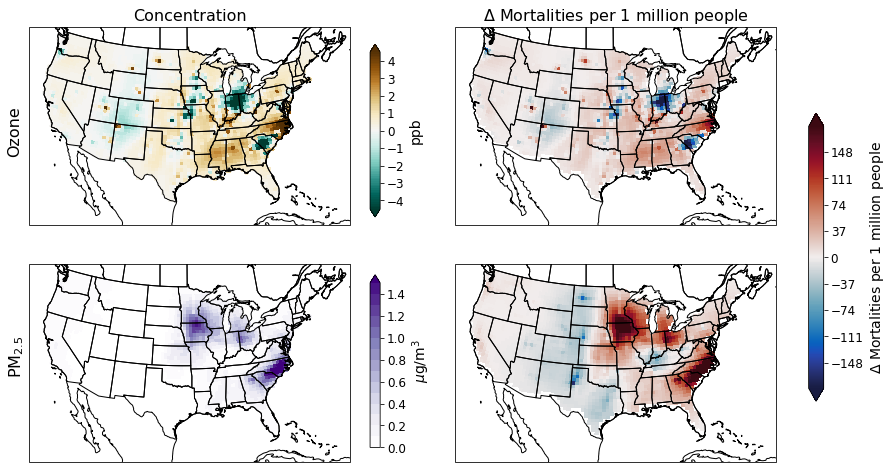

In [50]:
fig = plt.figure(figsize=[14,8])

### O3 No Nuclear plot ###
cmap = 'BrBG_r'
lev = np.squeeze(np.arange(-184,184.5,.5))
lev_pol =  np.squeeze(np.arange(-4.5,4.6,.1))
ax_o3 = fig.add_subplot(2,2,1, projection=ccrs.LambertConformal())
o3 = (ds_seasonal['O3'].sel(season ='JJA', model_name = 'nonuc_coal_NA')-ds_seasonal['O3'].sel(season ='JJA', model_name = 'normal_NA')).plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev_pol, 
                                                                                  extend = 'both')
ax_o3.set_title('Concentration', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent([-120,-70,20,50])

## O3 colorbarr ##
cbar_ax = fig.add_axes([.48, 0.55, 0.01, 0.3])
cb = fig.colorbar(o3, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'ppb', fontsize=14)
cb.ax.tick_params(labelsize='large')


### O3 No Nuclear Mortalities ###
cmap = cmocean.cm.balance
ax_o3_mort = fig.add_subplot(2,2,2, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_o3['regrid_pop_count']).plot(ax = ax_o3_mort,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_mort.set_title('$\Delta$ Mortalities per 1 million people', fontsize = 16)
ax_o3_mort.add_feature(cfeat.STATES)
ax_o3_mort.coastlines()
ax_o3_mort.set_extent([-120,-70,20,50])

### PM No Nuclear plot ###
cmap = 'Purples'
lev_pol =  np.squeeze(np.arange(0,1.6,.1))
ax_pm = fig.add_subplot(2,2,3, projection=ccrs.LambertConformal())
pm = (ds_seasonal['PM25'].sel( model_name = 'nonuc_coal_NA')-ds_seasonal['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'season').plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev_pol, 
                                                         extend = 'max')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent([-120,-70,20,50])

## PM colorbar ##
cbar_ax = fig.add_axes([.48, 0.15, 0.01, 0.3])
cb = fig.colorbar(pm, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'$\mu$g/m$^3$', fontsize=14)
cb.ax.tick_params(labelsize='large')


### PM No Nuclear Mortalities###
cmap = cmocean.cm.balance
ax_pm_mort = fig.add_subplot(2,2,4, projection=ccrs.LambertConformal())
(1e6*ds_PM['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_PM['regrid_pop_count']).plot(ax = ax_pm_mort, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_mort.set_title(r' ', fontsize = 16)
ax_pm_mort.add_feature(cfeat.STATES)
ax_pm_mort.coastlines()
ax_pm_mort.set_extent([-120,-70,20,50])



### Mortality color bar #####
cbar_ax = fig.add_axes([.915, 0.23, 0.015, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')


### Titles ###

fig.text(.12,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.12,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

#plt.tight_layout()
plt.savefig('./Figures/mortalities_poll_nonuc_coal.png', bbox_inches = 'tight', dpi = 150)